# GraphSet

この章では`GraphSet`モジュールが備えている主な機能を紹介します．Graphillionを用いたグラフ集合の処理は，ほぼ全て`GraphSet`クラスの機能を用いて実行できます．Graphillionを使ったグラフ集合の処理の具体例をもっと知りたい方は次章以降に進んでください．

GraphSetを用いたグラフ集合の処理は以下の手順で進みます．

1. 初期化 (universeの設定)
2. グラフ集合オブジェクトの作成
3. グラフ集合の操作・変換
4. グラフ集合に対する問い合わせ（最適化，数え上げ等）

解きたい課題によっては手順2-4を繰り返すことによって課題を解決することになります．以下ではそれぞれの手順に対応する`GraphSet`の機能を紹介していきます．より詳しい説明については[Graphillionの公式ドキュメント](https://github.com/takemaru/graphillion/wiki)を参照ください．

## 初期化処理

Graphillionを利用するためには，初期化処理が必ず必要となります．初期化処理は`universe`となるグラフ`univ`を引数として`GraphSet.set_universe(univ)`メソッドを呼ぶことで実行できます．

まず`GraphSet`クラスをインポートします．

In [ ]:
!pip install graphillion
!git clone https://github.com/nsnmsak/graphillion_tutorial
!cp graphillion_tutorial/ja/tutorial_util.py .

     |████████████████████████████████| 1.1MB 9.4MB/s 
  Created wheel for graphillion: filename=Graphillion-1.4-cp36-cp36m-linux_x86_64.whl size=1728104 sha256=1fa38fe1f9b081c522ba7a7e1ef76bab60e05c1b3864b6526028a779fb85cb79
  Stored in directory: /root/.cache/pip/wheels/ea/b6/48/f470d2643c9413aa95781ea67c64bf1cfbd0a325cd3351d4e0
Successfully built graphillion
Cloning into 'graphillion_tutorial'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 261 (delta 157), reused 116 (delta 51), pack-reused 0
Receiving objects: 100% (261/261), 6.49 MiB | 11.63 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [ ]:
from graphillion import GraphSet
from tutorial_util import draw_subgraph, draw_universe

次に`GraphSet.set_universe()` で`universe`を設定します．

In [ ]:
univ = [(1, 2), (2, 3), (1, 4), (2, 5), (3, 6), (4, 5), (5, 6)]
GraphSet.set_universe(univ)

辺は頂点のペアとして表現され，`universe` は辺のリストとして表現されます．したがって`universe`は頂点ペアのリストとして表現されます．ここでは以下のグラフを`universe`として設定しました．

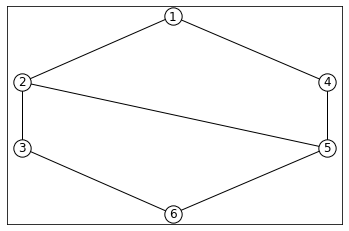

In [ ]:
draw_universe()

## グラフ集合の作成

次に問題解決に必要となるグラフ集合を表す`GraphSet`オブジェクトを構築します．構築するグラフ集合は目的によって異なります．例えば最短経路問題や最長経路問題を解きたいのであれば，すべての経路の集合を表す`GraphSet`オブジェクトをまず構築し，それをもとに微調整を加えることで目的の`GraphSet`を作成します．

### コンストラクタによるグラフ集合の作成

GraphSetモジュールにはグラフ集合を操作するための各種演算が揃っています．まずはグラフ集合を作成するための最も基本的な方法として，明示的にグラフの集合を指定して作成する方法があります．

In [ ]:
graph1 = [(1, 4)]
graｐh2 = [(1, 2), (2, 3)]

gs = GraphSet([graph1, graph2])
gs

GraphSet([[(1, 4)], [(1, 2), (2, 3)]])

`GraphSet`オブジェクトの初期化時にグラフ（辺を表す`tuple`の`list`）の`list`を渡すことで，それに対応する`GraphSet`を作成することができます．

また，空のリスト`[]`を引数としてコンストラクタに渡すと，空のグラフ集合が作成されます．

In [ ]:
gs = GraphSet([])
gs

GraphSet([])

もう一つの初期化方法として，部分グラフが含む辺のリストと，含まない辺のリストを指定する方法があります．

In [ ]:
gs = GraphSet({'include': graph1, 'exclude': graph2})
gs

GraphSet([[(1, 4)], [(1, 4), (4, 5)], [(1, 4), (2, 5)], [(1, 4), (3, 6)], [( ...

上の例で得られた`gs`は，辺`(1, 4)` を含みつつ，かつ`(1, 2)`, `(2, 3)`のいずれも含まないような部分グラフの集合を表現しています．

この初期化方法の特殊なケースとして，空の辞書オブジェクト`{}` を引数として渡すと，`universe`の全ての部分グラフからなる`GraphSet`オブジェクトを作成することができます．

In [ ]:
gs = GraphSet({})
gs

GraphSet([[], [(1, 4)], [(4, 5)], [(1, 2)], [(2, 5)], [(2, 3)], [(3, 6)], [( ...

辺の数が`n`本だったとすると，可能な部分グラフの数は$2^n$通りも存在することになります．そんな大きな部分グラフの集合を気軽に作っちゃうと処理が終わらなくならないか気になるところだと思いますが，ZDDを用いることで全ての部分グラフの集合は計算機上でとても小さく表現できています．

### 特定のグラフ集合に特化した構築法

Graphillionは上記のコンストラクタの他に，特定のグラフ集合に特化した構築法も提供しています．Graphillionを用いて問題を解く際には，経路や木，連結成分といった特定の種類のグラフ集合が必要な場面が多くあります．そうした事情に対処するために，Graphilionでは特定のグラフ集合に特化した構築法を取り揃えています．そのような構築方法の例を以下に挙げます．

| メソッド                                     | 説明                                                         |
| :------------------------------------------- | :----------------------------------------------------------- |
| `GraphSet.paths(s, t)`                       | 頂点`s`から`t`までの経路の集合を作成する．                   |
| `GraphSet.connected_components(vertices)`    | `vertices`に含まれるすべての頂点を連結とするような連結成分の集合を作成する． |
| `GraphSet.cliques(k)`                        | `k`個の頂点を含むクリークの集合を作成する．                  |
| `GraphSet.trees(root, is_spanning=False)`    | 根`root`を含む木の集合を作成する．`is_spanning=True`とすると全域木の集合を作成する． |
| `GraphSet.forests(roots, is_spanning=False)` | `roots`に含まれる各頂点を根とするような森 (木を集めたもの) を作成する．`is_spannnig=True`とすると全域森の集合を作成する． |
| `GraphSet.cycles(is_hamilton=False)`         | 閉路の集合を作成する．`is_hamilton=True`を設定すると，ハミルトン閉路の集合を作成する． |

ここに挙げたほかにも特定のGraphillionは特定のグラフ集合に特化した構築方法を提供しています．詳細はGraphillionの公式ドキュメントを参照ください．

いくつか具体的な実行例をみていきましょう．

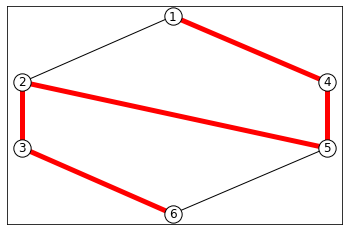

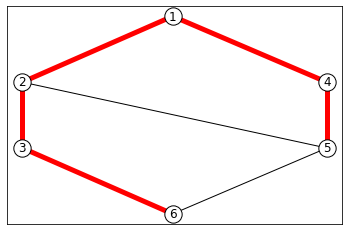

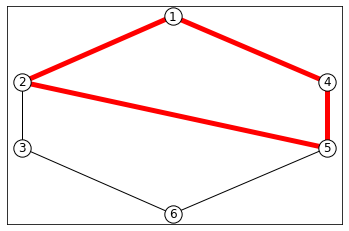

In [ ]:
paths = GraphSet.paths(1, 6) # 頂点1, 6間の経路の集合
draw_subgraph(subgraph=paths.choice())

trees = GraphSet.trees(1, is_spanning=True) #頂点 1を根とする全域木（全ての頂点を含む木）の集合
draw_subgraph(trees.choice())

cycles = GraphSet.cycles()
draw_subgraph(cycles.choice())

`gs.choice()`は`GraphSet`オブジェクトが表すグラフの集合からグラフを1つ取り出すメソッドです．

これらのグラフ構築メソッド群は，頻繁に用いられる機能への便利なインタフェースを提供している以上の意味をもちます．これらのメソッド内部ではグラフ集合に対応するZDDを高速に構築するための専用アルゴリズムが実行されます．以下ではこれらの`GraphSet`構築法を**目的特化構築法**とよびます．

目的特化構築法は通常のZDD構築法と比較して非常に高速に動作します．そのため，あるグラフ集合を表す`GraphSet`が必要な場合にはまず目的特化型構築法が利用できないかを検討することが重要です．

目的特化構築法の時間・空間計算量は，おおよそ構築されるZDDの頂点数に比例します．この事実は，ZDDを構築するために余計な計算が不要であるという意味では理想的です．しかし，構築されるZDDの大きさがどうなるかは実際に構築してみないとわかりません．[9章](09_practical_guide.ipynb)では目的特化型構築法で構築されるZDDの大きさを見積もるための指針について説明します．

## グラフ集合の操作，変換

ある`GraphSet`オブジェクトをを加工して別の`GraphSet`オブジェクトを作成する豊富な機能をGraphillionは提供しています．グラフ集合構築法でまず大元のグラフ集合を構築した後は，これらのグラフ集合操作機能を利用して所望の`GraphSet`を作り込んでいくことができます．代表的な操作はをいくつか紹介します．

 ### グラフ集合の二項演算

まずは２つの`GraphSet`オブジェクト`gs1`，`gs2`に対して合成演算を実行して新たな`GraphSet`オブジェクトを作成するメソッドの例です．

| メソッド                                     | Description                                                  |
| :-------------------------------------------- |:------------------------------------------------------------ |
| `gs1.union(gs2)`               | `gs1`と`gs2`のいずれかに含まれるグラフの集合を返す．         |
| `gs1.intersection(gs2)`        | `gs1`と`gs2` のどちらにも含まれるグラフの集合を返す．        |
| `gs.difference(gs2)`           | `gs1`に含まれていて，かつ`gs2`に含まれないグラフの集合を返す． |
| `gs1.symmetric_difference(gs2)` | `gs1`か`gs2`のどちらか片方にのみ含まれるグラフ集合を返す．   |
| `gs1.join(gs2)`                              | `gs1` と `gs2`の直積となるグラフ集合を返す．直積は$\{a \cup b \mid a \in \mathtt{gs1}, b \in \mathtt{gs2} \}$ として定義される集合． |
| `gs1.subgraphs(gs2)`                         | `gs1`に含まれるグラフのうち，`gs2`に含まれるいずれかのグラフの部分グラフになっているものからなるグラフ集合を返す． |
| `gs1.supergraphs(gs2)`                       | `gs1`に含まれるグラフのうち，`gs2`に含まれるいずれかのグラフを部分グラフとして含むものからなるグラフ集合を返す． |

演算の具体例です．

In [ ]:
graph1 = [(1, 4)]
graｐh2 = [(1, 2), (2, 3)]
gs1 = GraphSet([graph1])
gs2 = GraphSet([graph2])
gs1.union(gs2)

GraphSet([[(1, 4)], [(1, 2), (2, 3)]])

In [ ]:
graph1 = [(1, 4)]
graｐh2 = [(1, 2), (2, 3)]
gs1 = GraphSet([graph1, graph2])
gs2 = GraphSet([graph2])
intersection_gs = gs1.intersection(gs2)
intersection_gs

GraphSet([[(1, 2), (2, 3)]])

`gs.join`は２つのグラフ集合に含まれる各グラフを結合したグラフを作ります．

In [ ]:
graph1 = [(1, 4)]
graｐh2 = [(1, 2), (2, 3)]
gs1 = GraphSet([graph1])
gs2 = GraphSet([graph2])
join_gs = gs1.join(gs2)
join_gs

GraphSet([[(1, 2), (1, 4), (2, 3)]])

最悪の場合，これらの演算は`join`を除き`gs1`, `gs2` に対応するZDDの大きさの積に比例する実行時間がかかることが知られています．しかし実際には多くの場合で`gs1`, `gs2` および演算の結果得られるGraphSetオブジェクトのそれぞれにに対応するZDDのサイズの和の比例する時間で計算できます．`join`は最悪の場合にこれらの演算よりもさらに計算時間がかかることが知られていますが，現実的には他の演算との差を意識せずに利用しても大丈夫です．

### グラフ集合のフィルタリング

GraphSetオブジェクト`gs`に含まれるグラフ集合のうち，条件を満たすものを取り出して新しい`GraphSet`オブジェクトを作成するメソッドの例です．

| メソッド            | Description                                                  |
|:------------------- |:------------------------------------------------------------ |
| `gs.including(obj)` | `gs`に含まれるグラフのうち，`obj`を含むものの集合を返す．`obj`はグラフ集合，グラフ，辺もしくは頂点） |
| `gs.excluding(obj)` | `gs`に含まれるグラフのうち，`obj`を含まないものの集合を返す．`obj`はグラフ集合，グラフ，辺もしくは頂点） |
| `gs.larger(size)`   | `gs`に含まれるグラフのうち，辺の数が`size+1`以上であるものからなるグラフ集合を返す． |
| `gs.smaller(size)`  | `gs`に含まれるグラフのうち，辺の数が`size`未満であるものからなるグラフ集合を返す． |
| `gs.complement()`   | `gs`に含まれないグラフの集合であるグラフ集合を返す．`GraphSet({}) - gs`と等しい． |

実行例です．

In [ ]:
graph1 = [(1, 4)]
graｐh2 = [(1, 2), (2, 3)]
gs = GraphSet([graph1, graph2])

print(gs.including(1))
print(gs.including((2, 3)))
print(gs.larger(2))
print(gs.complement())

GraphSet([[(1, 4)], [(1, 2), (2, 3)]])
GraphSet([[(1, 2), (2, 3)]])
GraphSet([])
GraphSet([[(1, 4), (2, 5), (3, 6), (4, 5), (5, 6)], [(1, 2), (2, 3), (2, 5), ...


二項演算と同様に，これらの演算もグラフ集合を表すZDDサイズに比例する計算時間がかかります．

## 演算の実行

### グラフ集合の性質の問い合わせ

所望のグラフ集合を表す`GraphSet`オブジェクトが作成できたら，それを用いて各種問い合わせに答えることができます．

| メソッド                | Description                                                  |
|:-----------------------|:------------------------------------------------------------|
| `obj in gs`             | `obj`が`gs`に含まれるときにTrueを返す．`obj`はグラフ，辺もしくは頂点． |
| `len(gs)`               | `gs`に含まれるグラフの数を返す．                             |
| `gs.probability(probs)` | 辞書オブジェクト`probs`で指定された確率分布に基づいて各辺がランダムに選択された場合に， `gs`に含まれるグラフが生成される確率を計算する．信頼性の計算で利用する． |

`obj in gs`の実行には`universe`に指定したグラフの辺の数に対して線形の時間がかかります．`len(gs)`, `gs.probability(probs)`の実行には，`GraphSet`オブジェクトに対応するZDDの頂点数に対して線形の計算時間がかかります．確率を計算する`gs.probability`については○章のネットワーク信頼性の計算の応用例で利用方法を詳しく解説します．

実行例です．

In [ ]:
graph1 = [(1, 4)]
graｐh2 = [(1, 2), (2, 3)]
gs = GraphSet([graph1, graph2])

print([(1, 4)] in gs)
print(len(gs))

True
2


### イテレータによる要素の抽出，列挙

`GraphSet`から要素を取り出す計算は，Pythonのイテレータを用いて実装されています．各種メソッドが返したイテレータを用いることで，最大・最小の要素を取り出したり，グラフのランダムサンプリングが実行できます．


| メソッド         | Description                                                  |
|:----------------|:------------------------------------------------------------ |
| `iter(gs)`       | `gs`に含まれるグラフに順にアクセスするイテレータを返す．     |
| `gs.rand_iter()` | `gs`に含まれるグラフをランダムに取り出すイテレータを返す．同じ要素が二度以上取り出されることもある． |
| `gs.min_iter(weights)`  | `gs`に含まれるグラフを重みの和が小さい順に取り出す．         |
| `gs.max_iter(weights)`  | `gs`に含まれるグラフを重みの和が大きい順に取り出す．         |

実行例です．

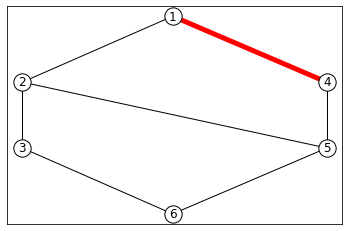

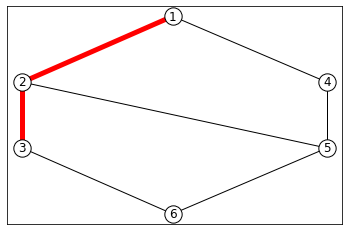

In [ ]:
for graph in gs:
      draw_subgraph(graph)

イテレータを用いることで，最短経路問題や最長経路問題のように，重みが最大もしくは最小の要素を取り出す問題も解くことができます．

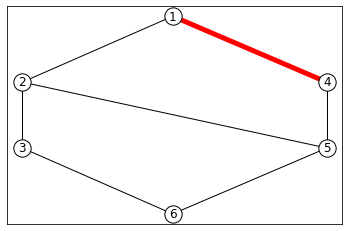

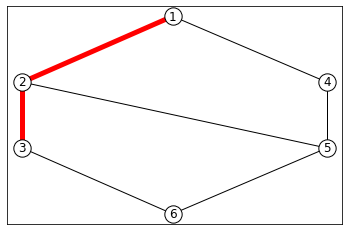

In [ ]:
min_graph = next(gs.min_iter()) # gsに含まれるもののうち，辺の数が最小のものを選択
draw_subgraph(min_graph)

max_graph = next(gs.max_iter()) # gsに含まれるもののうち，辺の数が最小のものを選択
draw_subgraph(max_graph)

## まとめ

この章ではGraphillionの中心的な機能である，`GraphSet`クラスについて解説しました．この章で紹介した順番でGraphSetの初期化，構築，操作，問い合わせを実行することによってグラフに関する問題を解決することができます．[次章](07_answering_path_query.ipynb)では`GraphSet`クラスの機能を活用して問題を解く方法を紹介します．